# Imports

## Packages

In [2]:
import torch.optim
from torch.utils import data
import argparse
import json
from tqdm import tqdm
import sys
import clip
sys.path.append('/home/guest/Documents/Siraj TM/RSCaMa')
from model.model_encoder_attMamba import Encoder, AttentiveEncoder
from model.model_decoder import DecoderTransformer
from utils_tool.utils import *
from data.LEVIR_CC.LEVIRCC import LEVIRCCDataset
from torch import nn, einsum

from PIL import Image
from imageio import imread
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import time

/home/guest/anaconda3/envs/RSCaMa_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.device_count()

2

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device("cuda:1")

In [5]:
!nvidia-smi

Mon Mar 31 16:38:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.28.03              Driver Version: 560.28.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:65:00.0 Off |                  Off |
| 30%   40C    P8             10W /  230W |   11142MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Functions

In [6]:
def load_json(path):
    with open(path) as f:
        file = json.load(f)
    f.close()
    return file
def save_json(file,path):
    with open(path,'w') as f:
        json.dump(file,f)
    f.close()
    print("Saved Successfully")
def rem_print(word):
    t_word = word
    for _ in range(100 - len(t_word)):
        word = word + ' '
    print(word,end='\r')

## Data

In [7]:
word_vocab = load_json('assets/vocab.json')

In [8]:
train_dir = 'data/Levir-CC-dataset/images/train'

# Training

## Imports

In [9]:
from torch.utils import data
from torch.nn.utils.rnn import pack_padded_sequence

## Functions

## Data

In [10]:
train_loader = data.DataLoader(
                LEVIRCCDataset('CLIP-ViT-B/32','data/Levir-CC-dataset/images', '/home/guest/Documents/Siraj TM/RSCaMa/data/LEVIR_CC/', 'train', '/home/guest/Documents/Siraj TM/RSCaMa/data/LEVIR_CC/tokens/', word_vocab, 42, 1),
                batch_size=64, shuffle=True, num_workers=24, pin_memory=True)

In [11]:
val_loader = data.DataLoader(
                LEVIRCCDataset('CLIP-ViT-B/32','data/Levir-CC-dataset/images', '/home/guest/Documents/Siraj TM/RSCaMa/data/LEVIR_CC/', 'val', '/home/guest/Documents/Siraj TM/RSCaMa/data/LEVIR_CC/tokens/', word_vocab , 42, 1),
                batch_size=64, shuffle=False, num_workers=24, pin_memory=True)

## Model

In [39]:
model, preprocess = clip.load("ViT-B/32", device=device)

In [12]:
encoder = Encoder('CLIP-ViT-B/32')
encoder.fine_tune(True)
encoder_trans = AttentiveEncoder(n_layers=3,
                                        feature_size=[7, 7, 768],
                                        heads=8, dropout=0.1,device=device)
decoder = DecoderTransformer(decoder_type='transformer_decoder',embed_dim=768,
                                    vocab_size=len(word_vocab), max_lengths=42,
                                    word_vocab=word_vocab, n_head=8,
                                    n_layers=1, dropout=0.1,device=device)

decoder_n_layers= 1
decoder_type= transformer_decoder


In [18]:
!nvidia-smi

Mon Mar 31 16:39:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.28.03              Driver Version: 560.28.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:65:00.0 Off |                  Off |
| 30%   40C    P8             10W /  230W |   11142MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [14]:
num_epochs = 25

In [15]:
encoder_optimizer = torch.optim.Adam(params=encoder.parameters(),
                                            lr=1e-4) if True else None
encoder_trans_optimizer = torch.optim.Adam(
    params=filter(lambda p: p.requires_grad, encoder_trans.parameters()),
    lr=1e-4)
decoder_optimizer = torch.optim.Adam(
    params=filter(lambda p: p.requires_grad, decoder.parameters()),
    lr=1e-4)

# Move to GPU, if available
encoder.cuda(device)
encoder_trans.cuda(device)
decoder.cuda(device)
encoder_lr_scheduler = torch.optim.lr_scheduler.StepLR(encoder_optimizer, step_size=5,
                                                            gamma=1.0) if True else None
encoder_trans_lr_scheduler = torch.optim.lr_scheduler.StepLR(encoder_trans_optimizer, step_size=5,
                                                                    gamma=1.0)
decoder_lr_scheduler = torch.optim.lr_scheduler.StepLR(decoder_optimizer, step_size=5,
                                                            gamma=1.0)
hist = np.zeros((num_epochs*2 * len(train_loader), 5))

l_resizeA = torch.nn.Upsample(size = (256, 256), mode ='bilinear', align_corners = True)
l_resizeB = torch.nn.Upsample(size = (256, 256), mode ='bilinear', align_corners = True)
index_i = 0

## Training Step

In [17]:
encoder.train()
encoder_trans.train()
decoder.train()
criterion_cap = torch.nn.CrossEntropyLoss().cuda(device)
criterion_cap_cls = torch.nn.CrossEntropyLoss().cuda(device)

In [23]:


print_freq = 100
EPOCHS = num_epochs

for epoch in range(EPOCHS):
    for id,batch_data in enumerate(train_loader):
        
        start_time = time.time()
        accum_steps = 64//64
        
        #Getting Data and moving to GPU if possible
        imgA = batch_data['imgA']
        imgB = batch_data['imgB']
        token = batch_data['token']
        token_len = batch_data['token_len']
        imgA = imgA.cuda(device)
        imgB = imgB.cuda(device)
        token = token.cuda(device)
        token_len = token_len.cuda(device)
        
        #Feat1 and Feat2
        feat1, feat2 = encoder(imgA, imgB)
        feat = encoder_trans(feat1, feat2)
        scores, caps_sorted, decode_lengths, sort_ind = decoder(feat, token, token_len)
        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]
        
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data
        
        loss = criterion_cap(scores, targets.to(torch.int64))
        
        loss = loss / accum_steps
        loss.backward()
        
        if (id + 1) % accum_steps == 0 or (id + 1) == len(train_loader):
            decoder_optimizer.step()
            encoder_trans_optimizer.step()
            if encoder_optimizer is not None:
                encoder_optimizer.step()

            # Adjust learning rate
            decoder_lr_scheduler.step()
            encoder_trans_lr_scheduler.step()
            if encoder_lr_scheduler is not None:
                encoder_lr_scheduler.step()

            decoder_optimizer.zero_grad()
            encoder_trans_optimizer.zero_grad()
            if encoder_optimizer is not None:
                encoder_optimizer.zero_grad()
                
        hist[index_i, 0] = time.time() - start_time #batch_time
        hist[index_i, 1] = loss.item()  # train_loss
        hist[index_i, 2] = accuracy_v0(scores, targets, 5) #top5
        
        index_i += 1
        
        if index_i % (print_freq) == 0:
            print(f'Training Epoch: {epoch} | Index:{index_i} | Loss: {loss}\n')
        rem_print(f'Training Epoch: {epoch} | Index:{index_i} | Loss: {loss}')

Training Epoch: 0 | Index:200 | Loss: 1.9663019180297852                                            

Training Epoch: 1 | Index:300 | Loss: 1.6814106702804565                                            

Training Epoch: 2 | Index:400 | Loss: 1.4670134782791138                                            

Training Epoch: 3 | Index:500 | Loss: 1.4476122856140137                                            

Training Epoch: 4 | Index:600 | Loss: 1.5778120756149292                                            

Training Epoch: 5 | Index:700 | Loss: 1.4598031044006348                                            

Training Epoch: 5 | Index:800 | Loss: 1.1045427322387695                                            

Training Epoch: 6 | Index:900 | Loss: 1.2898590564727783                                            

Training Epoch: 7 | Index:1000 | Loss: 1.4540414810180664                                           

Training Epoch: 8 | Index:1100 | Loss: 1.3448060750961304                         

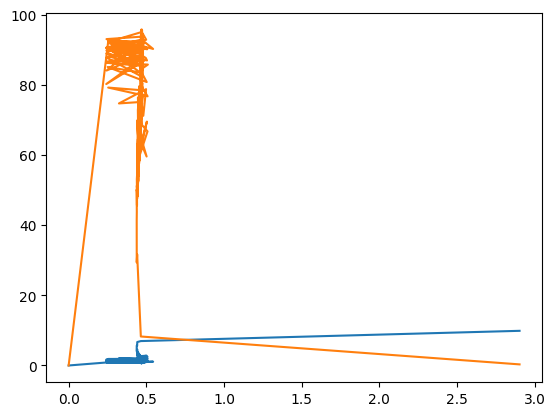

In [28]:
plt.plot(hist[:,0],hist[:,1])
plt.plot(hist[:,0],hist[:,2])

In [30]:
torch.save(encoder.state_dict(),'data/Pre-Trained Models/encoder.pth')
torch.save(encoder_trans.state_dict(),'data/Pre-Trained Models/encoder_trans.pth')
torch.save(decoder.state_dict(),'data/Pre-Trained Models/decoder.pth')

# Inferencing

In [31]:
def get_tokens(index):
    
    Path = 'data/Levir-CC-dataset/images/'
    Image_name = Captions['images'][index]['filename']
    dir_path = Path + '/' +  Captions['images'][index]['filepath']
    
    ImA =  f"{dir_path}/A/{Image_name}"
    ImB =  f"{dir_path}/B/{Image_name}"
       
    Ground_truth = Captions['images'][index]['sentences'][0]['raw']
    
    IMA = preprocess(Image.fromarray(
        io.imread(ImA)
        )).unsqueeze(0).to(device)
    
    IMB = preprocess(Image.fromarray(
        io.imread(ImB)
        )).unsqueeze(0).to(device)
    
    
    with torch.no_grad():
        feat1,feat2 = encoder(IMA,IMB)
        feat = encoder_trans(feat1,feat2)
        seq = decoder.sample(feat,k=1)
        
    pred_seq = [w for w in seq if w not in except_tokens]
    caption = [invert[token] for token in pred_seq]
    
    output = ''
    for word in caption:
        output += word + ' '
        
    print(f"Predicted_Caption : {output}\tGround Truth : {Ground_truth} ")

    fig,axes = plt.subplots(1,2)
    axes[0].set_title(f"Before - Index:{index}")
    axes[0].imshow(np.asarray(Image.open(ImA)))
    axes[0].axis('off')
    
    axes[1].set_title(f"After - Index:{index}")
    axes[1].imshow(np.asarray(Image.open(ImB)))
    axes[1].axis('off')
    plt.show()

In [36]:
Captions = load_json("data/Levir-CC-dataset/LevirCCcaptions.json")
test_path = 'data/Levir-CC-dataset/images/test'
invert = {val:key for key,val in word_vocab.items()}
except_tokens = {word_vocab['<START>'], word_vocab['<END>'], word_vocab['<NULL>']}
except_tokens

{0, 2, 3}

Predicted_Caption : some trees are removed and some buildings appear 	Ground Truth :  some trees are removed and a road is built . 


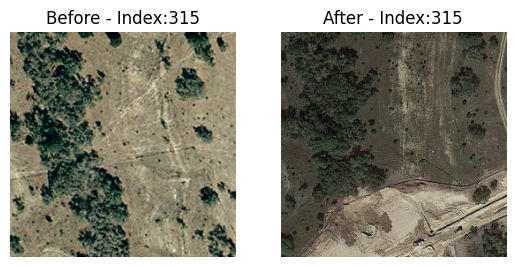

Predicted_Caption : some houses are built in the top right 	Ground Truth :  some trees in the woods are removed and some villas are built there . 


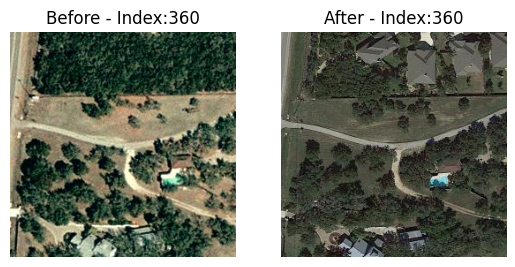

Predicted_Caption : a row of villas have been built along the road 	Ground Truth :  several houses are built at the bottom . 


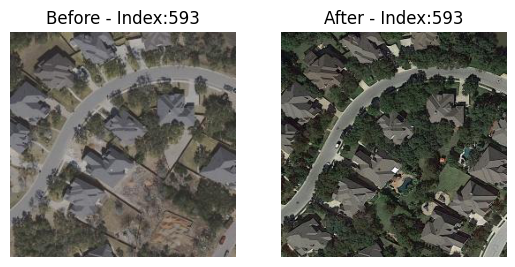

Predicted_Caption : a road is built across the area 	Ground Truth :  there is no difference . 


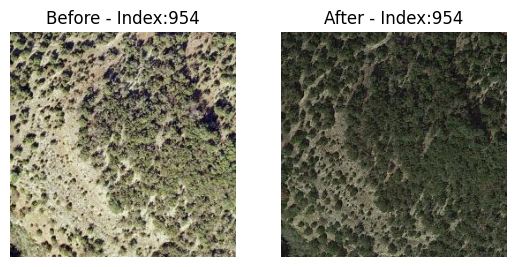

Predicted_Caption : a road is built near the original one 	Ground Truth :  a parking lot and a house appear on the bareland . 


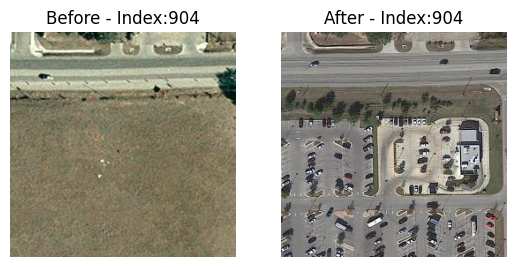

Predicted_Caption : a road has been built with many houses are constructed on both sides of the road 	Ground Truth :  many trees are removed and the roads extend with many buildings neatly arranged . 


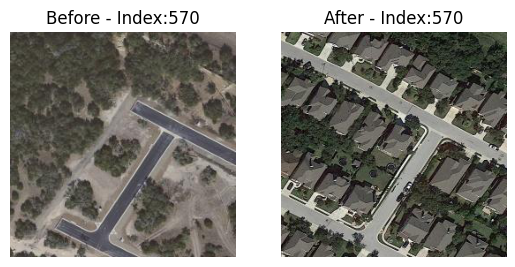

Predicted_Caption : a house appears in the right corner of the scene 	Ground Truth :  several ponds appear in the right of the scene . 


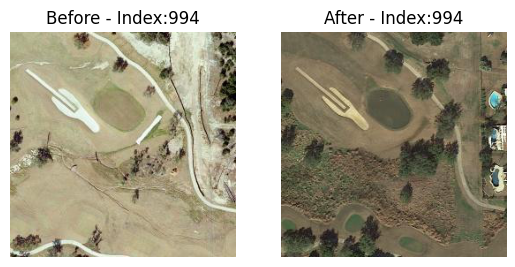

Predicted_Caption : some buildings appear in the forest 	Ground Truth :  some buildings are scattered in the forest . 


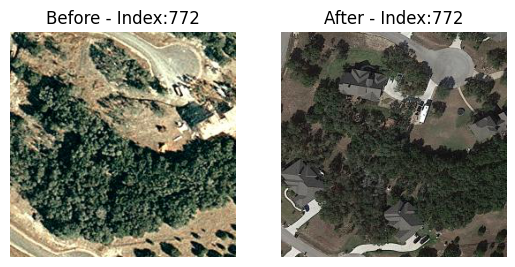

Predicted_Caption : a road has been built with some houses are constructed on the bareland 	Ground Truth :  a residential area and a road replace many plants . 


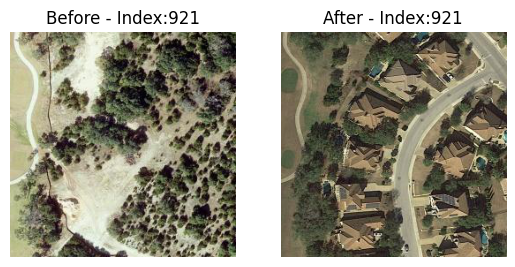

Predicted_Caption : the scene is the same as before 	Ground Truth :  there is no difference . 


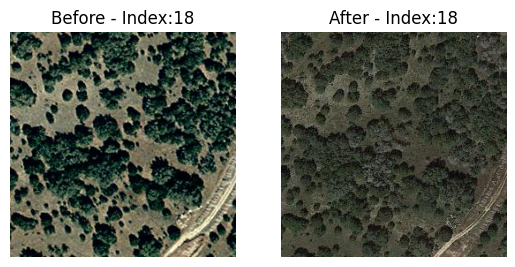

In [42]:
for index in [random.randint(0,1000) for _ in range(10)]:
    get_tokens(index)